# Message Board App

we will use a database for the first time to build a basic Message Board application where users can post and read short messages. We’ll explore Django’s powerful built-in admin interface which provides a visual way to make changes to our data. And after adding tests we will push our code to GitHub and deploy the app on Heroku.

there is built-in support for multiple database backends: PostgreSQL, MySQL, MariaDB, Oracle, or SQLite. This means that we, as developers, can write the same Python code in a models.py file and it will automatically be translated into each database correctly. The only configuration required is to update the DATABASES64 section of our config/settings.py file.


For local development, Django defaults to using SQLite65 because it is file-based and therefore far simpler to use than the other database options, which require a dedicated server to be running separate from Django itself.

# Initial Set Up

We need to do the following:
• create a new directory for our code on the Desktop called mb

 • install Django in a new virtual environment

• createanewprojectcalledconfig

• createanewappcallposts

• updateconfig/settings.py

In [ ]:
$ cd ~/Desktop
$ mkdir mb && cd mb
$ pipenv install django~=3.1.0
$ pipenv shell
(mb) $ django-admin startproject config .
(mb) $ python manage.py startapp posts

Next we must alert Django to the new app, posts, by adding it to the top of the INSTALLED_APPS section of our config/settings.py file.

In [ ]:
# config/settings.py
INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'posts', # new
]

Then execute the migrate command to create an initial database based on Django’s default settings.

In [ ]:
(mb) $ python manage.py migrate

If you look inside our directory with the ls command, you’ll see there’s now a db.sqlite3 file representing our SQLite66 database.

In [ ]:
(mb) $ ls
Pipfile    Pipfile.lock    config    db.sqlite3    manage.py    posts

to make sure the database ref lects the current state of your project you’ll need to run migrate (and also makemigrations) each time you update a model.

To confirm everything works correctly, spin up our local server.

In [ ]:
(mb) $ python manage.py runserver

In your web browser, navigate to http://127.0.0.1:8000/ to see the familiar Django welcome page.

# Create a database model

Our first task is to create a database model where we can store and display posts from our users.

 Django’s ORM will automatically turn this model into a database table for us. In a real-world

Open the posts/models.py file and look at the default code which Django provides:

In [ ]:
# posts/models.py
from django.db import models

# Create your models here

We want to create a model to store the textual content of a message board post, which we can do as follows:

In [ ]:
# posts/models.py
from django.db import models
class Post(models.Model):
   text = models.TextField()

Note that we’ve created a new database model called Post which has the database field text. We’ve also specified the type of content it will hold, TextField(). Django provides many model fields68 supporting common types of content such as characters, dates, integers, emails, and so on.

# Activating models

Now that our new model is created we need to activate it. Going forward, whenever we create or modify an existing model we’ll need to update Django in a two-step process:

1. First,wecreateamigrationsfilewiththemakemigrationscommand.Migrationfilescreate a reference of any changes to the database models which means we can track changes–and debug errors as necessary–over time.

2. Second, we build the actual database with the migrate command which executes the instructions in our migrations file.

Make sure the local server is stopped by typing Control+c on the command line and then run the commands python manage.py makemigrations posts and python manage.py migrate.

In [ ]:
(mb) $ python manage.py makemigrations posts
Migrations for 'posts':
  posts/migrations/0001_initial.py
    - Create model Post
(mb) $ python manage.py migrate
Operations to perform:
  Apply all migrations: admin, auth, contenttypes, posts, sessions
Running migrations:
  Applying posts.0001_initial... OK

as a best practice, adopt the habit of always including the name of an app when executing the makemigrations command!

# Django Admin

To use the Django admin, we first need to create a superuser who can log in. In your command line console, type python manage.py createsuperuser and respond to the prompts for a username, email, and password:

In [ ]:
(mb) $ python manage.py createsuperuser
Username (leave blank to use 'wsv'): wsv
Email: will@learndjango.com
Password:
Password (again):
Superuser created successfully.

Restart the Django server with python manage.py runserver and in your web browser go to http://127.0.0.1:8000/admin/. You should see the log in screen for the admin:

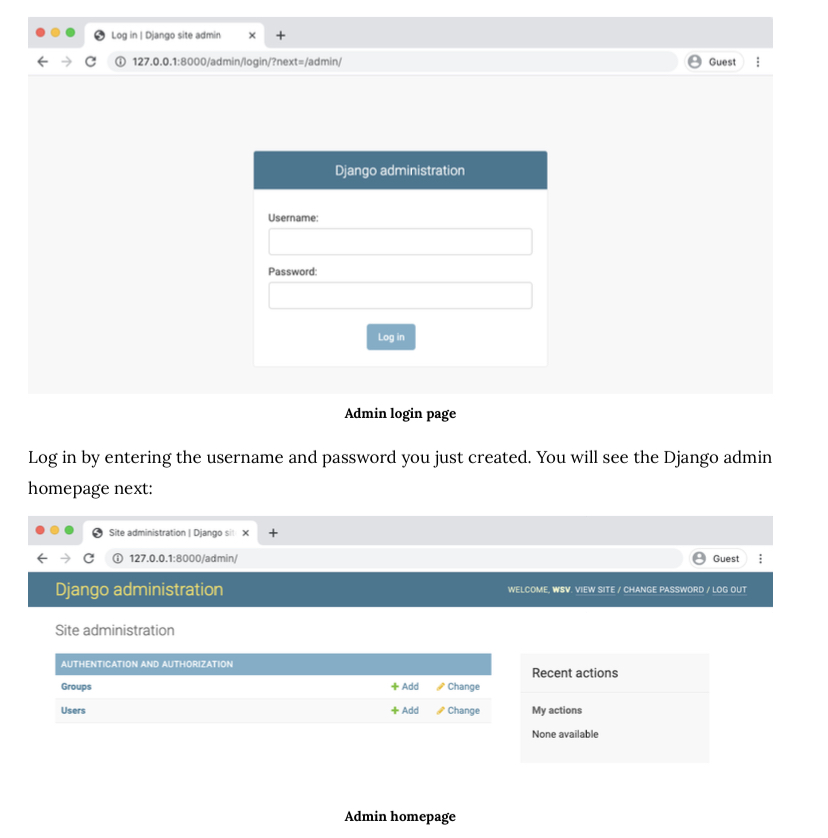

Just as we must explicitly add new apps to the INSTALLED_APPS config, so, too, must we update
an app’s admin.py file for it to appear in the admin.

In your text editor open up posts/admin.py and add the following code so that the Post model is displayed.

In [ ]:
# posts/admin.py
from django.contrib import admin

from .models import Post

admin.site.register(Post)

Django now knows that it should display our posts app and its database model Post on the admin page. If you refresh your browser you’ll see that it appears:

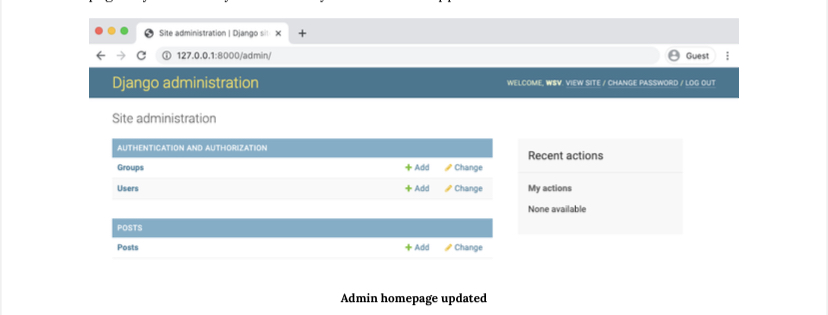

Let’s create our first message board post for our database. Click on the + Add button opposite Posts and enter your own content in the Text form field.

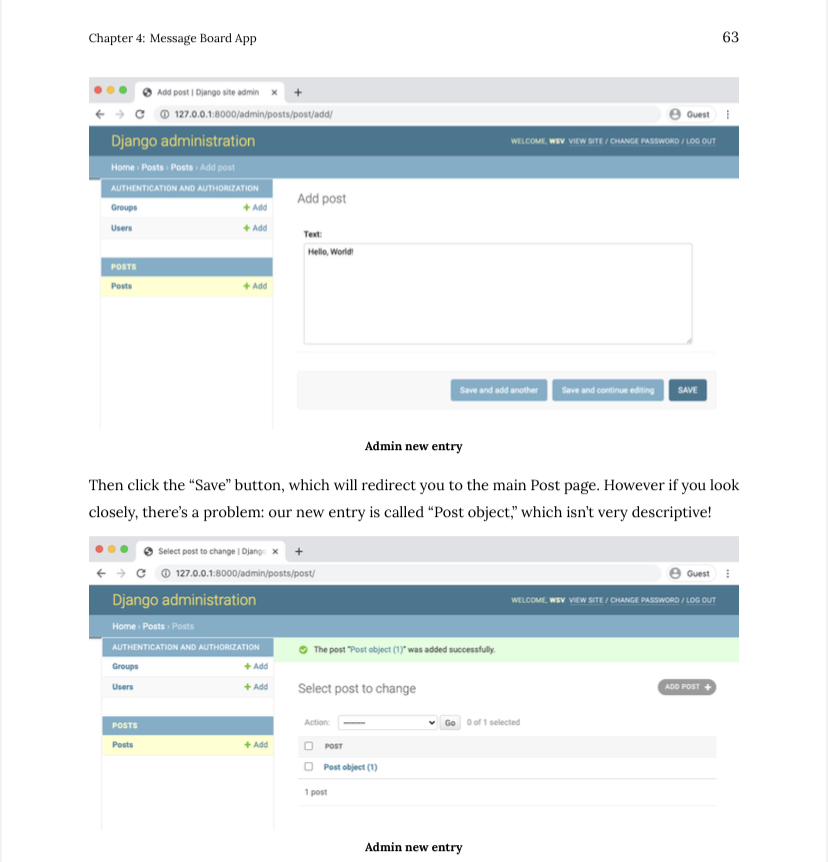

Let’s change that. Within the posts/models.py file, add a new function __str__ as follows:

In [ ]:
# posts/models.py
from django.db import models

class Post(models.Model):
  text = models.TextField()

  def __str__(self): return self.text[:50]

This will display the first 50 characters of the text field. If you refresh your Admin page in the browser, you’ll see it’s changed to a much more descriptive and helpful representation of our database entry.

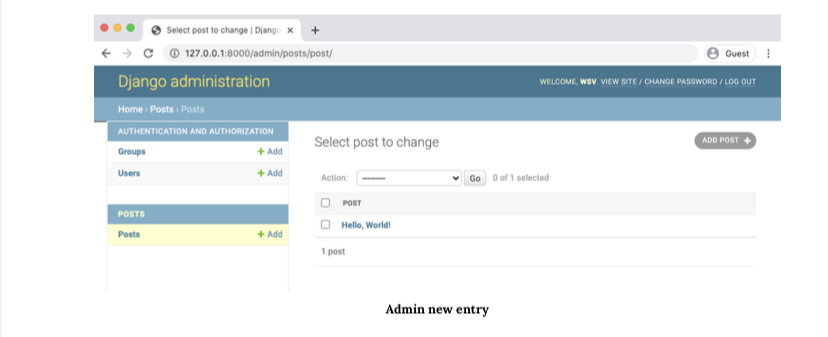

It’s a best practice to add str() methods to all of your models to improve their readability.

# Views/Templates/URLs

In order to display our database content on our homepage, we have to wire up our views, templates, and URLConfs.

In the posts/views.py file enter the Python code below:

In [ ]:
# posts/views.py
from django.views.generic import ListView

from .models import Post
class HomePageView(ListView):
    model = Post
    template_name = 'home.html'

Our view is complete which means we still need to configure our URLs and make our template. Let’s start with the template. Create a new directory called templates and within it a home.html template file.

In [ ]:
(mb) $ mkdir templates
(mb) $ touch templates/home.html

Then update the DIRS field in our config/settings.py file so that Django knows to look in this templates directory.

In [ ]:
# config/settings.py
TEMPLATES = [
    {
        ...
        'DIRS': [str(BASE_DIR.joinpath('templates'))], # new
        ...
}, ]

ListView automatically returns to us a context variable called object_list that we can loop over via the built-in for72 template tag. We’ll create our own variable called post and can then access the desired field we want displayed, text, as post.text.

In [ ]:
<!-- templates/home.html -->
<h1>Message board homepage</h1>
<ul>
   {% for post in object_list %}
      <li>{{ post.text }}</li>
   {% endfor %}
</ul>

The name object_list isn’t very friendly, is it? Instead we can provide an explicit name via context_object_name73 attribute. Django is, as ever, eminently customizable.
Back in our posts/views.py file add the following:

In [ ]:
# posts/views.py
from django.views.generic import ListView
from .models import Post


class HomePageView(ListView): model = Post
    template_name = 'home.html'
    contenxt_object_name = 'all_posts_list' # new

Don’t forget to update our template, too, so that it references all_posts_list rather than object_list.

In [ ]:
<!-- templates/home.html -->
<h1>Message board homepage</h1>
 <ul>
   {% for post in all_posts_list %}
      <li>{{ post.text }}</li>
   {% endfor %}
 </ul>

The last step is to set up our URLConfs. Let’s start with the config/urls.py file where we include our posts app and add include on the second line.

In [ ]:
# config/urls.py
from django.contrib import admin
from django.urls import path, include # new

urlpatterns = [
    path('admin/', admin.site.urls),
    path('', include('posts.urls')), # new
]

Then create a urls.py file within the posts app.

In [ ]:
(mb) $ touch posts/urls.py

And update it like so:

In [ ]:
# posts/urls.py
from django.urls import path
from .views import HomePageView


urlpatterns = [
    path('', HomePageView.as_view(), name='home'),
]

Restart the server with python manage.py runserver and navigate to our homepage, which now lists out our message board post.

We’re basically done at this point, but let’s create a few more message board posts in the Django admin to confirm that they will display correctly on the homepage.

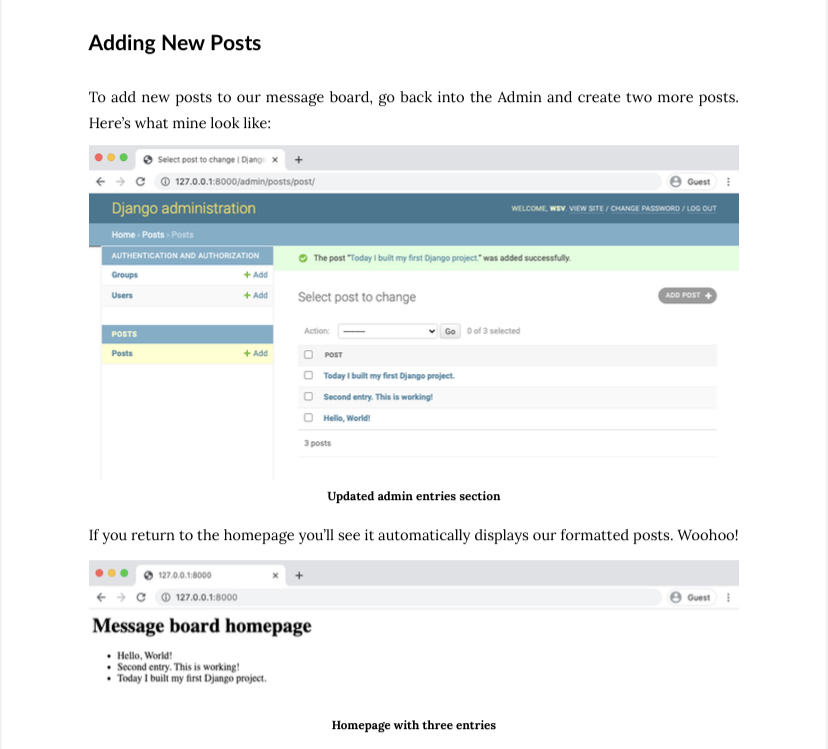

Everything works so it’s a good time to initialize our directory, add the new code, and include our first git commit.

In [ ]:
(mb) $ git init
(mb) $ git add -A
(mb) $ git commit -m "initial commit"

# Tests

Previously, we were only testing static pages so we used SimpleTestCase74. But now that our homepage works with a database, we need to use TestCase75, which will let us create a “test” database we can check against. In other words, we don’t need to run tests on our actual database but instead can make a separate test database, fill it with sample data, and then test against that which is a must safer and more performant approach.

Let’s start by adding a sample post to the text database field and then check that it is stored correctly in the database. It’s important that all our test methods start with the phrase test_ so that Django knows to test them! The code will look like this:

In [ ]:
# posts/tests.py
from django.test import TestCase
from .models import Post


class PostModelTest(TestCase):
   def setUp(self):
        Post.objects.create(text='just a test')


   def test_text_content(self):
        post=Post.objects.get(id=1)
        expected_object_name = f'{post.text}'
        self.assertEqual(expected_object_name, 'just a test')

At the top we imported the TestCase module which lets us create a sample database and our Post model. We created a new class, PostModelTest, and added a setUp method to create a new database that has just one entry: a post with a text field containing the string ‘just a test.’

Then we can run our first test, test_text_content, to check that the database field actually contains just a test. We created a variable called post that represents the first id on our Post model.

Remember that Django automatically sets this id for us. If we created another entry it would have an id of 2, the next one would be 3, and so on.

The next line uses f strings76, a very cool addition to Python 3.6, which let us put variables directly in our strings as long as the variables are surrounded by brackets {}. Here we’re setting expected_object_name to be the string of the value in post.text, which should be just a test.

On the final line we use assertEqual77 to check that our newly created entry does in fact match what we input at the top. Go ahead and run the test on the command line with command python manage.py test.

In [ ]:
(mb) $ python manage.py test
Creating test database for alias 'default'...
System check identified no issues (0 silenced).
.
----------------------------------------------------------------------
Ran 1 test in 0.001s
OK
Destroying test database for alias 'default'...

Time for our next group of tests. The first test looked at the model but now we want evaluate the homepage itself:

• does it actually exist and return a HTTP 200 response?

• doesituseHomePageViewastheview?

• doesitusehome.htmlasthetemplate?

We can include all of these tests in a new class called HomePageViewTest. Note that rather than access the view name directly we will instead import reverse78 and refer to the named URL of home. Why do it this way? URL schemes can and do change over the course of a project, but the named URL likely will not so this is a way to future-proof your tests.


We’ll need to add one more import at the top for reverse and a brand new class HomePageViewTest for our test.

In [ ]:
# posts/tests.py
from django.test import TestCase
from django.urls import reverse # new
from .models import Post

class PostModelTest(TestCase):
   def setUp(self):
        Post.objects.create(text='just a test')


   def test_text_content(self):
        post=Post.objects.get(id=1)
        expected_object_name = f'{post.text}'
        self.assertEqual(expected_object_name, 'just a test')


class HomePageViewTest(TestCase): # new def setUp(self):
        Post.objects.create(text='this is another test')

    def test_view_url_exists_at_proper_location(self):
        resp = self.client.get('/')
        self.assertEqual(resp.status_code, 200)

    def test_view_url_by_name(self):
        resp = self.client.get(reverse('home'))
        self.assertEqual(resp.status_code, 200)


     def test_view_uses_correct_template(self):
        resp = self.client.get(reverse('home'))
        self.assertEqual(resp.status_code, 200)
        self.assertTemplateUsed(resp, 'home.html')

If you run our tests again you should see that they pass

In [ ]:
(mb) $ python manage.py test
Creating test database for alias 'default'...
System check identified no issues (0 silenced).
.
----------------------------------------------------------------------
Ran 4 tests in 0.015s
OK
Destroying test database for alias 'default'...

We’re done adding code for our testing so it’s time to commit the changes to git.

In [ ]:
(mb) $ git add -A
(mb) $ git commit -m "added tests"
(mb) $ git remote add origin https://github.com/wsvincent/mb-app.git
(mb) $ git push -u origin master

# Heroku Configuration

Our deployment checklist contains the same three items:

• installGunicorn

• addaProcfile

• updateALLOWED_HOSTS
Gunicorn can be installed via Pipenv.

In [ ]:
(mb) $ pipenv install gunicorn==19.9.0

Then create a Procfile with Heroku instructions.

In [ ]:
(mb) $ touch Procfile

Add one line instructing Heroku to use Gunicorn as our production web server.

In [ ]:
web: gunicorn config.wsgi --log-file -

Previously, we set ALLOWED_HOSTS to *, meaning accept all hosts, but that was a dangerous shortcut. We can, and should be, more specific.

The two local hosts Django runs on are localhost:8000 and 127.0.0.1:8000. We also know, having deployed on Heroku previously, that any Heroku site will end with .herokuapp.com. We can add all three routes to our config.

In [ ]:
# config/settings.py
ALLOWED_HOSTS = ['.herokuapp.com', 'localhost', '127.0.0.1']

We’re all done! Add and commit our new changes to git and then push them up to GitHub.

In [ ]:
(mb) $ git status
(mb) $ git add -A
(mb) $ git commit -m "New updates for Heroku deployment"
(mb) $ git push -u origin master

# HEROKU DEPLOYMENT

In [ ]:
(mb) $ heroku login

Then run the create command and Heroku will randomly generate an app name.

In [ ]:
(mb) $ heroku create
Creating app... done, â¬¢ sleepy-brook-64719
https://sleepy-brook-64719.herokuapp.com/ |
https://git.heroku.com/sleepy-brook-64719.git

For now, continue to instruct Heroku to ignore static files.

In [ ]:
(mb) $ heroku config:set DISABLE_COLLECTSTATIC=1

Push the code to Heroku and add free scaling so it’s actually running online, otherwise the code is just sitting there!

In [ ]:
(mb) $ git push heroku master
(mb) $ heroku ps:scale web=1

You can open the URL of the new project from the command line by typing heroku open which will launch a new browser window.

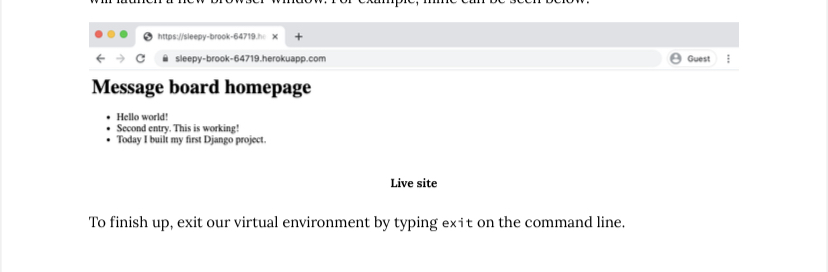

if you check your Heroku site in a few days, it’s likely whatever posts you’ve added will be deleted! This is related to how Heroku handles SQLite, but really it’s an indication that we should be using a production database like PostgreSQL for deployments, even if we still want to stick with SQLite locally.